In [1]:
!git clone https://github.com/pangeo-data/WeatherBench

'git' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
%cd /content/WeatherBench

[WinError 3] The system cannot find the path specified: '/content/WeatherBench'
C:\Users\Leighton\Downloads\Python\Python


In [3]:
!pip install ConfigArgParse

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
from src.score import *
from collections import OrderedDict

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm
from src.train_nn import *

ModuleNotFoundError: No module named 'src'

In [6]:
%cd /content/geopotential_5001

[WinError 3] The system cannot find the path specified: '/content/geopotential_5001'
C:\Users\Leighton\Downloads\Python\Python


In [7]:
# This might take a few minutes
!wget "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip" -O geopotential_500 --no-check-certificate

--2022-11-07 18:53:31--  https://dataserv.ub.tum.de/s/m1524895/download?path=/5.625deg/geopotential_500&files=geopotential_500_5.625deg.zip


In [8]:
!unzip geopotential_500

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
%cd /content/temperature_850

[WinError 3] The system cannot find the path specified: '/content/temperature_850'
C:\Users\Leighton\Downloads\Python\Python


In [10]:
# This might take a few minutes
!wget "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Ftemperature_850&files=temperature_850_5.625deg.zip" -O temperature_850 --no-check-certificate

--2022-11-07 18:53:40--  https://dataserv.ub.tum.de/s/m1524895/download?path=/5.625deg/temperature_850&files=temperature_850_5.625deg.zip


In [11]:
!unzip temperature_850

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
%cd /content/total_precipitation

[WinError 3] The system cannot find the path specified: '/content/total_precipitation'
C:\Users\Leighton\Downloads\Python\Python


In [13]:
# This might take a few minutes
!wget "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Ftotal_precipitation&files=total_precipitation_5.625deg.zip" -O total_precipitation --no-check-certificate

--2022-11-07 18:53:48--  https://dataserv.ub.tum.de/s/m1524895/download?path=/5.625deg/total_precipitation&files=total_precipitation_5.625deg.zip


In [14]:
!unzip total_precipitation

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
%cd /content/2m_temperature

[WinError 3] The system cannot find the path specified: '/content/2m_temperature'
C:\Users\Leighton\Downloads\Python\Python


In [16]:
# This might take a few minutes
!wget "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2F2m_temperature&files=2m_temperature_5.625deg.zip" -O 2m_temperature --no-check-certificate

--2022-11-07 18:53:51--  https://dataserv.ub.tum.de/s/m1524895/download?path=/5.625deg/2m_temperature&files=2m_temperature_5.625deg.zip


In [17]:
!unzip 2m_temperature

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## 1-Linear regression baseline

In [18]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [19]:
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

## Load and prepare data for training

In [20]:
# Load the entire dataset for the relevant variables
z500 = xr.open_mfdataset('/content/geopotential_5001/*.nc', combine='by_coords').z
t850 = xr.open_mfdataset('/content/temperature_850/*.nc', combine='by_coords').t.drop('level')
tp = xr.open_mfdataset('/content/total_precipitation/*.nc', combine='by_coords').tp.rolling(time=6).sum()
tp.name = 'tp'
t2m = xr.open_mfdataset('/content/2m_temperature/*.nc', combine='by_coords').t2m
data = xr.merge([z500, t850, tp, t2m])

OSError: no files to open

In [21]:
# Load the validation subset of the data: 2017 and 2018
z500_test = load_test_data('/content/geopotential_5001', 'z')
t850_test = load_test_data('/content/temperature_850', 't')
tp_test = load_test_data('/content/total_precipitation', 'tp').rolling(time=6).sum()
tp_test.name = 'tp'
t2m_test = load_test_data('/content/2m_temperature', 't2m')
test_data = xr.merge([z500_test, t850_test, tp_test, t2m_test],compat='override')

NameError: name 'load_test_data' is not defined

In [21]:
# The first 7+6 values of tp are missing, so let's just start after that
data.tp[:6+7+1].mean(('lat', 'lon')).compute()

NameError: name 'data' is not defined

In [22]:
data = data.isel(time=slice(7+6, None))

NameError: name 'data' is not defined

In [23]:
# Split into train and test data
# Yes, technically we should have a separate validation set but for LR this shouldn't matter.
data_train = data.sel(time=slice('2015', '2016'))
# data_train = data.sel(time=slice('2016', '2016'))
data_test = data.sel(time=slice('2017', '2018'))

NameError: name 'data' is not defined

In [24]:
# Compute normalization statistics
# Let's only take a sample of the time to speed this up.
data_mean = data_train.isel(time=slice(0, None, 10000)).mean().load()
data_std = data_train.isel(time=slice(0, None, 10000)).std().load()

NameError: name 'data_train' is not defined

In [25]:
# Normalize datasets
data_train = (data_train - data_mean) / data_std
data_test = (data_test - data_mean) / data_std

NameError: name 'data_train' is not defined

In [26]:
_, nlat, nlon = data_train.z.shape; nlat, nlon

NameError: name 'data_train' is not defined

In [27]:
data_train.z.isel(time=0).plot()

NameError: name 'data_train' is not defined

In [28]:
data_train.t.isel(time=0).plot()

NameError: name 'data_train' is not defined

In [29]:
data_train

NameError: name 'data_train' is not defined

In [30]:
def create_training_data(da, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = da.isel(time=slice(0, -lead_time_h))
    y = da.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

## Train linear regression

In [30]:
def train_lr(lead_time_h, input_vars, output_vars, data_subsample=1):
    """Create data, train a linear regression and return the predictions."""
    X_train, y_train, X_test, y_test = [], [], [], []
    for v in input_vars:
        X, y = create_training_data(
            data_train[v],
            lead_time_h
        )
        
        X_train.append(X)
        if v in output_vars: y_train.append(y)
        X, y, valid_time = create_training_data(data_test[v], lead_time_h, return_valid_time=True)
        X_test.append(X)
        if v in output_vars: y_test.append(y)
    X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]
    
    X_train = X_train[::data_subsample]
    y_train = y_train[::data_subsample]
    
    lr = LinearRegression(n_jobs=16)
    lr.fit(X_train, y_train)
    
    mse_train = mean_squared_error(y_train, lr.predict(X_train))
    mse_test = mean_squared_error(y_test, lr.predict(X_test))
    print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
    preds = lr.predict(X_test).reshape((-1, len(output_vars), nlat, nlon))
    
    fcs = []
    for i, v in enumerate(output_vars):
        fc = xr.DataArray(
            preds[:, i] * data_std[v].values + data_mean[v].values, 
            dims=['time', 'lat', 'lon'],
            coords={
                'time': valid_time,
                'lat': data_train.lat,
                'lon': data_train.lon
            },
            name=v
        )
        fcs.append(fc)
    return xr.merge(fcs), lr

In [31]:
experiments = [
    [['z'], ['z']],
    [['t'], ['t']],
    [['z', 't'], ['z', 't']],
    [['tp'], ['tp']],
    [['z', 't', 'tp'], ['tp']],
    [['t2m'], ['t2m']],
    [['z', 't', 't2m'], ['t2m']],
]

In [32]:
# Since training the LR on the full data takes up quite a lot of memory 
# we only take every 5th time step which gives almost the same results (<0.5% difference)
data_subsample = 5
lead_time = 3*24
preds = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    r = compute_weighted_rmse(p, test_data).compute()
    print('; '.join([f'{v} = {r[v].values}' for v in r]) + '\n')
    #p.to_netcdf(f'{PREDDIR}/lr_3d_{"_".join(i)}_{"_".join(o)}.nc');
    #to_pickle(m, f'{PREDDIR}/saved_models/lr_3d_{"_".join(i)}_{"_".join(o)}.pkl')

0: Input variables = ['z']; output variables = ['z']
Train MSE = 0.0033724636305123568
Test MSE = 0.18565255403518677
z = 1217.033193414435

1: Input variables = ['t']; output variables = ['t']
Train MSE = 0.00430930033326149
Test MSE = 0.16439715027809143
t = 5.411611110108333

2: Input variables = ['z', 't']; output variables = ['z', 't']
Train MSE = 8.390144898839935e-07
Test MSE = 0.39079412817955017
z = 1596.4227555538955; t = 9.460806439006696

3: Input variables = ['tp']; output variables = ['tp']
Train MSE = 0.2769237160682678
Test MSE = 3.7112178802490234
tp = 0.004287829942368935

4: Input variables = ['z', 't', 'tp']; output variables = ['tp']
Train MSE = 1.1034701856260654e-05
Test MSE = 9.137212753295898
tp = 0.006727552890751688

5: Input variables = ['t2m']; output variables = ['t2m']
Train MSE = 0.0016065877862274647
Test MSE = 0.05996362119913101
t2m = 4.111671788110297

6: Input variables = ['z', 't', 't2m']; output variables = ['t2m']
Train MSE = 1.7670235763489472e-

In [33]:
# Same for 5 days
data_subsample = 5
lead_time = 5*24
preds = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    r = compute_weighted_rmse(p, test_data).compute()
    print('; '.join([f'{v} = {r[v].values}' for v in r]) + '\n')
    #p.to_netcdf(f'{PREDDIR}/lr_5d_{"_".join(i)}_{"_".join(o)}.nc');
    #to_pickle(m, f'{PREDDIR}/saved_models/lr_5d_{"_".join(i)}_{"_".join(o)}.pkl')

0: Input variables = ['z']; output variables = ['z']
Train MSE = 0.0036963727325201035
Test MSE = 0.22712278366088867
z = 1346.3603797033848

1: Input variables = ['t']; output variables = ['t']
Train MSE = 0.004466235637664795
Test MSE = 0.1798475980758667
t = 5.6549539404216445

2: Input variables = ['z', 't']; output variables = ['z', 't']
Train MSE = 1.0409313517811825e-06
Test MSE = 0.4166514277458191
z = 1695.6424622469347; t = 9.663522046776357

3: Input variables = ['tp']; output variables = ['tp']
Train MSE = 0.2743324935436249
Test MSE = 3.739083766937256
tp = 0.0043009947414660125

4: Input variables = ['z', 't', 'tp']; output variables = ['tp']
Train MSE = 4.673016519518569e-06
Test MSE = 9.057755470275879
tp = 0.006690934958783043

5: Input variables = ['t2m']; output variables = ['t2m']
Train MSE = 0.0016632983461022377
Test MSE = 0.06738565117120743
t2m = 4.359948219480022

6: Input variables = ['z', 't', 't2m']; output variables = ['t2m']
Train MSE = 2.2141909994388698e

In [34]:
def create_iterative_fc(state, model, lead_time_h=6, max_lead_time_h=5*24):
    max_fc_steps = max_lead_time_h // lead_time_h
    fcs_z500, fcs_t850 = [], []
    for fc_step in tqdm(range(max_fc_steps)):
        state = model.predict(state)
        fc_z500 = state[:, :nlat*nlon].copy() * data_std.z.values + data_mean.z.values
        fc_t850 = state[:, nlat*nlon:].copy() * data_std.t.values + data_mean.t.values
        fc_z500 = fc_z500.reshape((-1, nlat, nlon))
        fc_t850 = fc_t850.reshape((-1, nlat, nlon))
        fcs_z500.append(fc_z500); fcs_t850.append(fc_t850)

    return [xr.DataArray(
        np.array(fcs), 
        dims=['lead_time', 'time', 'lat', 'lon'],
        coords={
            'lead_time': np.arange(lead_time_h, max_lead_time_h + lead_time_h, lead_time_h),
            'time': z500_test.time,
            'lat': z500_test.lat,
            'lon': z500_test.lon
        }
    ) for fcs in [fcs_z500, fcs_t850]]

In [35]:
p, m = train_lr(6, input_vars=['z', 't'], output_vars=['z', 't'], data_subsample=5)

Train MSE = 4.3850013753399253e-07
Test MSE = 0.14875194430351257


## 2- climatological forecast

In [42]:
z500 = xr.open_mfdataset('/content/geopotential_5001/*.nc', combine='by_coords')

In [43]:
# To speed things up we will just take the mean for 2016
climatology = z500.sel(time=slice('2016', '2016')).mean('time').load()

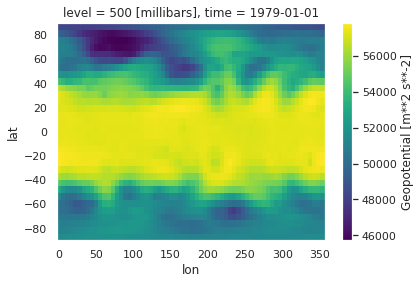

In [44]:
# Plot an example
z500.z.isel(time=0).plot();

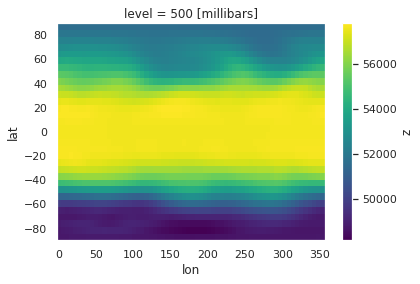

In [45]:
climatology.z.plot()

In [46]:
z500_test = load_test_data('/content/geopotential_5001/', 'z')[::12]  # Take data only every 12 hours to speed up computation on Binder

In [47]:
rmse_climatology = compute_weighted_rmse(climatology.z, z500_test).load()

In [48]:
rmse_climatology

<xarray.DataArray ()>
array(1079.88382283)
Coordinates:
    level    int32 500

## 3- Neural Network

In [49]:
bs = 32
lead_time = 5*24
var_dict = {'z': None}

In [50]:
# Use 2015 for training and 2016 for validation
dg_train = DataGenerator(z500.sel(time=slice('2015', '2015')), var_dict, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(z500.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, 
                         mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM


In [51]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(z500.sel(time=slice('2017', '2018')).isel(time=slice(0, None, 12)), # Limiting the data for Binder
                        var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [52]:
X, y = dg_train[0]

In [53]:
# Batches have dimensions [batch_size, lat, lon, channels]
X.shape, y.shape

((32, 32, 64, 1), (32, 32, 64, 1))

In [54]:
cnn = keras.models.Sequential([
    PeriodicConv2D(filters=32, kernel_size=5, conv_kwargs={'activation':'relu'}, input_shape=(32, 64, 1,)),
    PeriodicConv2D(filters=1, kernel_size=5)
])

In [55]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 periodic_conv2d (PeriodicCo  (None, 32, 64, 32)       832       
 nv2D)                                                           
                                                                 
 periodic_conv2d_1 (Periodic  (None, 32, 64, 1)        801       
 Conv2D)                                                         
                                                                 
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [56]:
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

In [57]:
# Train a little bit ;)
cnn.fit(dg_train, epochs=1, validation_data=dg_valid)

270/270 [==============================] - 99s 364ms/step - loss: 1.7602 - val_loss: 0.9982


In [58]:
preds = create_predictions(cnn, dg_test)

/content/WeatherBench/src/train_nn.py:142: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(dg)


In [59]:
preds

<xarray.Dataset>
Dimensions:  (time: 1340, lat: 32, lon: 64)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-02 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 5.139e+04 5.147e+04 ... 5.323e+04

In [60]:
compute_weighted_rmse(preds.z, z500_test).load()

<xarray.DataArray ()>
array(1225.06401164)
Coordinates:
    level    int32 500

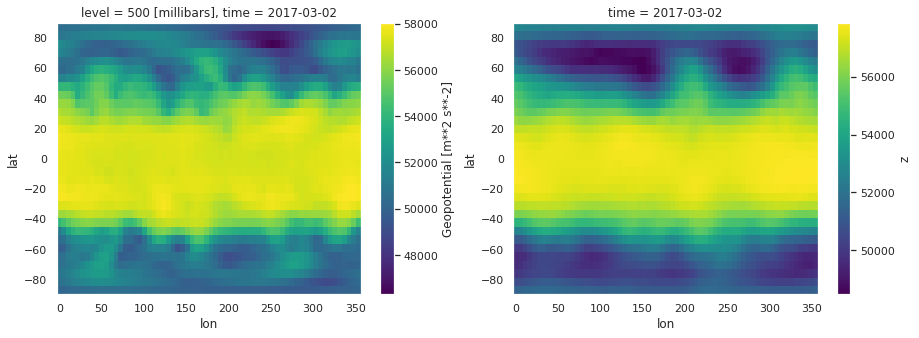

In [61]:
time = '2017-03-02T00'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
z500_test.sel(time=time).plot(ax=ax1)
preds.sel(time=time).z.plot(ax=ax2);

## 4- CNN

In [62]:
tf.__version__

'2.9.2'

In [63]:
def limit_mem():
    """By default TF uses all available GPU memory. This function prevents this."""
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)

In [64]:
limit_mem()

In [65]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [66]:
z = xr.open_mfdataset('/content/geopotential_5001/*.nc', combine='by_coords')
t = xr.open_mfdataset('/content/temperature_850/*.nc', combine='by_coords').drop('level')

In [67]:
# For the data generator all variables have to be merged into a single dataset.
datasets = [z, t]
ds = xr.merge(datasets)

In [68]:
# In this notebook let's only load a subset of the training data
ds_train = ds.sel(time=slice('2015', '2016'))  
ds_test = ds.sel(time=slice('2017', '2018'))

In [69]:
# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'z': None, 't': None})

In [70]:
bs=32
lead_time=6

In [71]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(ds_train.sel(time=slice('2015', '2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(ds_train.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM


In [72]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 2)>
 array([54124.863,   274.798], dtype=float32)
 Coordinates:
   * level    (level) int64 500 500, <xarray.DataArray 'z' (level: 2)>
 array([1110.2052   ,    5.6419535], dtype=float32)
 Coordinates:
   * level    (level) int64 500 500)

In [73]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [74]:
## Create and train model
class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

In [75]:
def build_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = PeriodicConv2D(f, k)(x)
        x = LeakyReLU()(x)
        if dr > 0: x = Dropout(dr)(x)
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)

In [76]:
cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 2))

In [77]:
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

In [78]:
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 2)]       0         
                                                                 
 periodic_conv2d_2 (Periodic  (None, 32, 64, 64)       3264      
 Conv2D)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 64, 64)        0         
                                                                 
 periodic_conv2d_3 (Periodic  (None, 32, 64, 64)       102464    
 Conv2D)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 64, 64)        0         
                                                                 
 periodic_conv2d_4 (Periodic  (None, 32, 64, 64)       102464

In [ ]:
# Since we didn't load the full data this is only for demonstration.
cnn.fit(dg_train, epochs=100, validation_data=dg_valid, 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=2,
                        verbose=1, 
                        mode='auto'
                    )]
         )

In [82]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cnn.save_weights('/content/saved_models/fccnn_6h.h5')

In [83]:
# Load weights from externally trained model
cnn.load_weights('/content/drive/MyDrive/fccnn_6h.h5')

In [84]:
## Create predictions
def create_predictions(model, dg):
    """Create predictions for non-iterative model"""
    preds = model.predict_generator(dg)
    # Unnormalize
    preds = preds * dg.std.values + dg.mean.values
    fcs = []
    lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None:
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx],
                dims=['time', 'lat', 'lon'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx:lev_idx+nlevs],
                dims=['time', 'lat', 'lon', 'level'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(fcs)

In [85]:
fc = create_predictions(cnn, dg_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


In [80]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data('/content/geopotential_5001', 'z')
t850_valid = load_test_data('/content/temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid],compat='override')

In [87]:
compute_weighted_rmse(fc, valid).compute()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 152.0
    t        float64 1.29

In [86]:
def create_iterative_predictions(model, dg, max_lead_time=1*24):
    state = dg.data[:dg.n_samples]
    preds = []
    for _ in range(max_lead_time // dg.lead_time):
        state = model.predict(state)
        p = state * dg.std.values + dg.mean.values
        preds.append(p)
    preds = np.array(preds)
    
    lead_time = np.arange(dg.lead_time, max_lead_time + dg.lead_time, dg.lead_time)
    das = []; lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None:
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx],
                dims=['lead_time', 'time', 'lat', 'lon'],
                coords={'lead_time': lead_time, 'time': dg.init_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx:lev_idx+nlevs],
                dims=['lead_time', 'time', 'lat', 'lon', 'level'],
                coords={'lead_time': lead_time, 'time': dg.init_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(das)

In [ ]:
fc_iter = create_iterative_predictions(cnn, dg_test)

134/548 [======>.......................] - ETA: 6:03

## END